In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
# Using plotly.express
import plotly.express as px
import matplotlib.pyplot as plt
pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.width',None)

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')

<Figure size 800x800 with 0 Axes>

In [26]:
sales_data = pd.read_csv("data/sales_by_dept.csv")
sales_data.Date = pd.to_datetime(sales_data.Date)
# sales_data = sales_data.sort_values(by = "Date")
sales_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [27]:
q = """
    Select A.Store, COUNT(DEPT) AS No_of_dept
    FROM
    (SELECT
        Store, DEPT
     FROM
        sales_data
     GROUP BY
        Store, Dept) A
    GROUP BY
        A.Store
    ORDER BY
        No_of_dept DESC
        """

store_no_of_dept = pysqldf(q)
store_no_of_dept.head()

,Store,No_of_dept
0,13,79
1,15,79
2,19,79
3,2,78
4,4,78


In [28]:
q = """SELECT
        Store, DEPT, COUNT(DEPT) as No_sold_per_dept
     FROM
        sales_data
     GROUP BY
        Store, Dept
    ORDER BY
        No_sold_per_dept DESC
        """

store_dept_no_of_sold_per_dept = pysqldf(q)
store_dept_no_of_sold_per_dept.head()

,Store,Dept,No_sold_per_dept
0,1,1,143
1,1,2,143
2,1,3,143
3,1,4,143
4,1,5,143


In [29]:
q = """SELECT
        Store, Dept, AVG(Weekly_Sales) as Avg_weekly_sales_per_dept
     FROM
        sales_data
     GROUP BY
        Store, Dept
    ORDER BY
        Avg_weekly_sales_per_dept DESC
        """

store_dept_avg_weekly_sale_per_dept = pysqldf(q)
store_dept_avg_weekly_sale_per_dept.head()

,Store,Dept,Avg_weekly_sales_per_dept
0,14,92,182527.956014
1,2,92,164840.230979
2,20,92,164633.741538
3,13,92,162034.099301
4,4,92,159365.107902


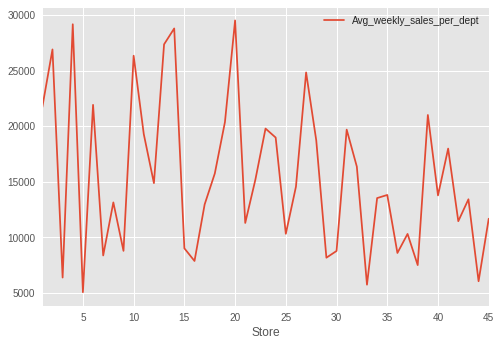

In [30]:
q = """SELECT
        Store, AVG(Weekly_Sales) as Avg_weekly_sales_per_dept
     FROM
        sales_data
     GROUP BY
        Store
    ORDER BY
        Store DESC
        """

store_avg_weekly_sale_per_dept = pysqldf(q)
store_avg_weekly_sale_per_dept.index = store_avg_weekly_sale_per_dept.Store
del store_avg_weekly_sale_per_dept['Store']
store_avg_weekly_sale_per_dept.plot()

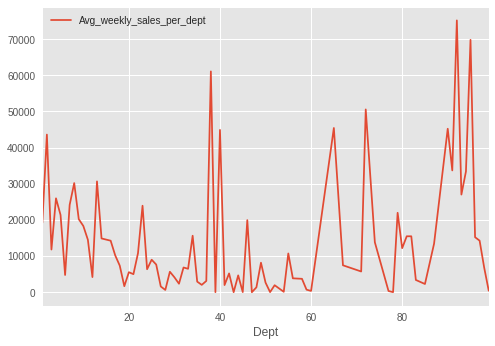

In [31]:
q = """SELECT
        DEPT, AVG(Weekly_Sales) as Avg_weekly_sales_per_dept
     FROM
        sales_data
     GROUP BY
        Dept
    ORDER BY
        Dept DESC
        """

dept_avg_weekly_sale_per_dept = pysqldf(q)
dept_avg_weekly_sale_per_dept.index = dept_avg_weekly_sale_per_dept.Dept
del dept_avg_weekly_sale_per_dept['Dept']
dept_avg_weekly_sale_per_dept.plot()

#### Taking store 1 first

In [36]:
sales_store1 = sales_data[sales_data['Store'] == 1]
sales_store1_dept1 = sales_store1[sales_store1['Dept'] == 1][['Date','Weekly_Sales']]
sales_store1_dept1.index = sales_store1_dept1['Date']
del sales_store1_dept1['Date']

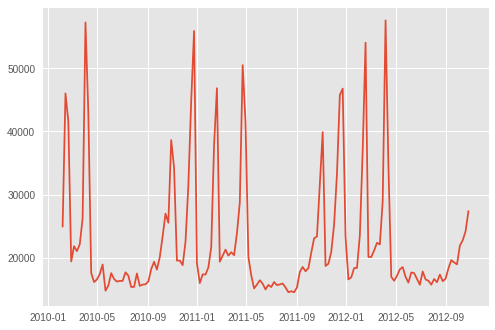

In [37]:
plt.plot(sales_store1_dept1.index, sales_store1_dept1['Weekly_Sales'])

### Checking Stationarity:
#### Dickey Fuller Test:


In [39]:
# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller

# Run test
result = adfuller(sales_store1_dept1['Weekly_Sales'])

# Print test statistic
print("test-statistics : ",result[0])

# Print p-value
print("p-value : ",result[1])

# Print critical values
print("critical values : ",result[4])

test-statistics :  -2.522163868650037
p-value :  0.11017432282586997
critical values :  {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}


Do not have enough evidence to reject the null hypothesis. Transforming the data

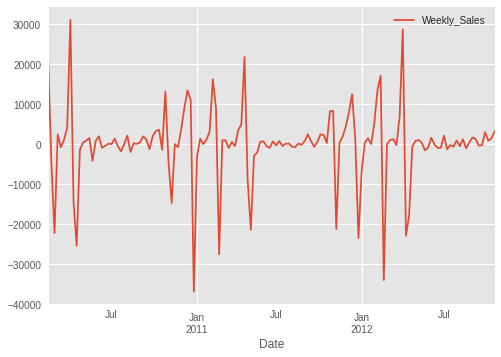

ADF Statistic: -11.044311466768818
p-value: 5.269934445888141e-20


In [45]:
# Calculate the first difference of the time series
sales_store1_dept1_stat = sales_store1_dept1.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(sales_store1_dept1_stat['Weekly_Sales'])

# Plot the differenced time series
fig, ax = plt.subplots()
sales_store1_dept1_stat.plot(ax=ax)
plt.show()

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [50]:
from statsmodels.tsa.arima_model import ARMA

# Instantiate the model
model = ARMA(sales_store1_dept1_stat, order=(2,0))

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:           Weekly_Sales   No. Observations:                  142
Model:                     ARMA(2, 0)   Log Likelihood               -1488.772
Method:                       css-mle   S.D. of innovations           8642.536
Date:                Mon, 20 Jan 2020   AIC                           2985.545
Time:                        23:04:56   BIC                           2997.368
Sample:                    02-12-2010   HQIC                          2990.349
                         - 10-26-2012                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -25.3060    540.511     -0.047      0.963   -1084.688    1034.076
ar.L1.Weekly_Sales     0.0033      0.080      0.042      0.967      -0.154       0.160
ar.L2.Weekly_Sales  

/home/sagnik/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



### Seasonal Transformation

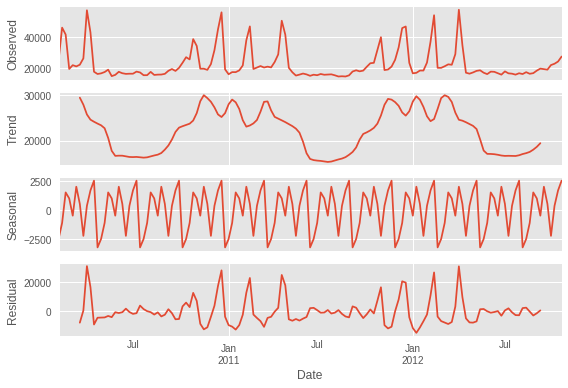

In [40]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Perform additive decomposition
decomp = seasonal_decompose(sales_store1_dept1['Weekly_Sales'], 
                            freq=12)

# Plot decomposition
decomp.plot()
plt.show()

### Automated ARIMA

In [42]:
import pmdarima as pm

# Create auto_arima model
model1 = pm.auto_arima(sales_store1_dept1,
                      seasonal=True, m=7,
                      d=0, D=1, 
                 	  max_p=2, max_q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)
                       
# Print model summary
print(model1.summary())

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 7); AIC=2850.395, BIC=2873.696, Fit time=4.193 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=2921.695, BIC=2927.520, Fit time=0.041 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=2879.172, BIC=2890.823, Fit time=0.379 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=2856.931, BIC=2868.581, Fit time=0.438 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=2919.980, BIC=2922.893, Fit time=0.032 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 7); AIC=2857.356, BIC=2877.745, Fit time=1.945 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 0, 7); AIC=2878.604, BIC=2898.993, Fit time=0.562 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 1, 7); AIC=2846.435, BIC=2872.649, Fit time=10.040 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 0, 7); AIC=2863.874, BIC=2887.175, Fit time=3.734 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_

In [43]:
# Create the 4 diagostics plots
results1 = model1.fit()
results1.plot_diagnostics()
plt.show()

TypeError: fit() missing 1 required positional argument: 'y'